#### Importing libraries

In [32]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import umap
from embeddings.infrastructure.json_loader import JSONArticleLoader
from embeddings.infrastructure.embedder_factory import EmbedderFactory

sys.path.append("../..") 

#### Loading articles from /embeddings/data/json

In [ ]:
json_folder = "../data/json"
loader = JSONArticleLoader(json_folder)
articles = loader.load_all()
texts = [a.to_text() for a in articles]

print(f"Loaded {len(articles)} articles.")

#### Generating embeddings

In [ ]:
models_to_test = ["st_minilm", "st_labse", "fasttext", "glove"]

embeddings_dict = {}

for model_name in models_to_test:
    try:
        embedder = EmbedderFactory.create(model_name)
        
        embeddings = embedder.embed(texts)
        embeddings_dict[model_name] = embeddings
        
        print(f"Model '{model_name}' OK, embedding shape: {len(embeddings[0])}")
    except Exception as e:
        print(f"Model '{model_name}' FAILED: {e}")

Model 'st_minilm' OK, embedding shape: 384
Model 'st_labse' OK, embedding shape: 768
Model 'fasttext' OK, embedding shape: 300
Model 'glove' OK, embedding shape: 300


In [6]:
model_name = "st_minilm"
for i, emb in enumerate(embeddings_dict[model_name][:3]):
    print(f"Article ID {articles[i].id} embedding preview (first 10 dims): {emb[:10]}")

Article ID WUT1eed12fc20d24416bc1d188f864789f7 embedding preview (first 10 dims): [-0.09498550742864609, -0.08131831884384155, 0.09674710780382156, 0.043176110833883286, 0.014279695227742195, -0.0460873581469059, 0.04617347568273544, -0.058402568101882935, -0.03029981069266796, -0.0747273713350296]
Article ID WUTe57092011f874e15acb6664443d72ba3 embedding preview (first 10 dims): [0.05423485487699509, 0.013363673351705074, -0.0059150103479623795, 0.011423716321587563, -0.009044639766216278, -0.018237914890050888, -0.005478124134242535, 0.027192354202270508, 0.01168903149664402, -0.00269772089086473]
Article ID WUT44679da7514146858c9a437671be57cb embedding preview (first 10 dims): [-0.10406529158353806, -0.05597023665904999, 0.02400861866772175, 0.02447349764406681, -0.05696257948875427, -0.08017971366643906, -0.02553069032728672, 0.05131467804312706, 0.038352422416210175, 0.019180946052074432]


In [ ]:
def plot_all_heatmaps(embeddings_dict, articles):
    ids = [a.id for a in articles]
    n_models = len(embeddings_dict)
    fig, axes = plt.subplots(1, n_models, figsize=(5 * n_models, 5))
    
    if n_models == 1:
        axes = [axes]
    
    for ax, (model_name, emb) in zip(axes, embeddings_dict.items()):
        sim_matrix = cosine_similarity(np.array(emb))
        sns.heatmap(sim_matrix, annot=False, cmap="viridis", ax=ax)
        ax.set_title(model_name)
        ax.set_xticks(range(len(ids)))
        ax.set_yticks(range(len(ids)))
    
    plt.tight_layout()
    plt.show()

In [28]:
def plot_all_tsne(embeddings_dict, articles, max_articles_for_tsne=50):
    ids = [a.id for a in articles]
    n_models = len(embeddings_dict)
    fig, axes = plt.subplots(1, n_models, figsize=(5 * n_models, 5))
    
    if n_models == 1:
        axes = [axes]
    
    for ax, (model_name, emb) in zip(axes, embeddings_dict.items()):
        emb = np.array(emb)
        if len(emb) > max_articles_for_tsne:
            emb_tsne = emb[:max_articles_for_tsne]
            ids_tsne = ids[:max_articles_for_tsne]
        else:
            emb_tsne = emb
            ids_tsne = ids
        
        tsne = TSNE(n_components=2, random_state=42)
        emb_2d = tsne.fit_transform(emb_tsne)
        ax.scatter(emb_2d[:,0], emb_2d[:,1], c='blue', alpha=0.7)
        ax.set_title(model_name)
        ax.set_xlabel("TSNE dim 1")
        ax.set_ylabel("TSNE dim 2")
        ax.grid(True)
        
    plt.tight_layout()
    plt.show()

In [42]:
def plot_all_umap(embeddings_dict, articles, max_articles_for_umap=50):
    ids = [a.id for a in articles]
    n_models = len(embeddings_dict)
    fig, axes = plt.subplots(1, n_models, figsize=(5 * n_models, 5))
    
    if n_models == 1:
        axes = [axes]
    
    for ax, (model_name, emb) in zip(axes, embeddings_dict.items()):
        emb = np.array(emb)
        if len(emb) > max_articles_for_umap:
            emb_umap = emb[:max_articles_for_umap]
            ids_umap = ids[:max_articles_for_umap]
        else:
            emb_umap = emb
            ids_umap = ids
        
        reducer = umap.UMAP(n_components=2)
        emb_2d = reducer.fit_transform(emb_umap)
        ax.scatter(emb_2d[:,0], emb_2d[:,1], c='green', alpha=0.7)
        ax.set_title(model_name)
        ax.set_xlabel("UMAP dim 1")
        ax.set_ylabel("UMAP dim 2")
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()
    

In [44]:
def plot_similarity_histograms(embeddings_dict):
    n_models = len(embeddings_dict)
    fig, axes = plt.subplots(1, n_models, figsize=(5 * n_models, 5))
    
    if n_models == 1:
        axes = [axes]
    
    for ax, (model_name, emb) in zip(axes, embeddings_dict.items()):
        emb = np.array(emb)
        sim_matrix = cosine_similarity(emb)
        upper_tri = sim_matrix[np.triu_indices_from(sim_matrix, k=1)]
        
        ax.hist(upper_tri, bins=50)
        ax.set_title(f"{model_name}")
        ax.set_xlabel("Cosine similarity")
        ax.set_ylabel("Frequency")
    
    plt.tight_layout()
    plt.show()

In [67]:
def silhouette_barplots(embeddings_dict, cluster_range=[2,3,4,5]):
    n_subplots = len(cluster_range)
    fig, axes = plt.subplots(1, n_subplots, figsize=(5*n_subplots, 5))
    
    if n_subplots == 1:
        axes = [axes]
    
    model_names = list(embeddings_dict.keys())
    
    for ax, n_clusters in zip(axes, cluster_range):
        scores = []
        for model_name, emb in embeddings_dict.items():
            emb = np.array(emb)
            kmeans = KMeans(n_clusters=n_clusters, random_state=42)
            cluster_labels = kmeans.fit_predict(emb)
            score = silhouette_score(emb, cluster_labels)
            scores.append(score)
        
        bars = ax.bar(range(len(model_names)), scores, color='skyblue')
        ax.set_title(f"K = {n_clusters}")
        ax.set_xticks(range(len(model_names)))
        ax.set_xticklabels(model_names, rotation=45, ha='right')
        ax.set_ylim(0,1)
        for bar, score in zip(bars, scores):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height()+0.02, f"{score:.2f}", 
                    ha='center', va='bottom', fontsize=8)
    
    plt.suptitle("Silhouette Score comparison for different K values", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


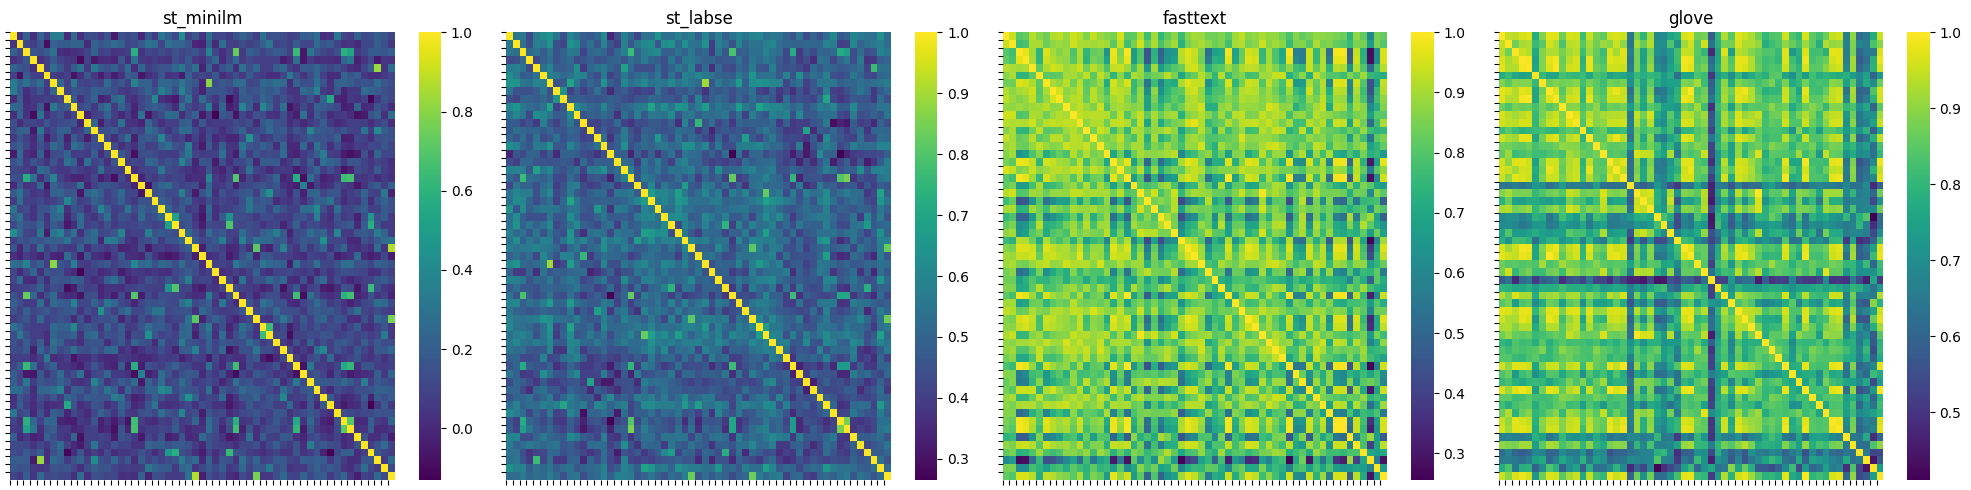

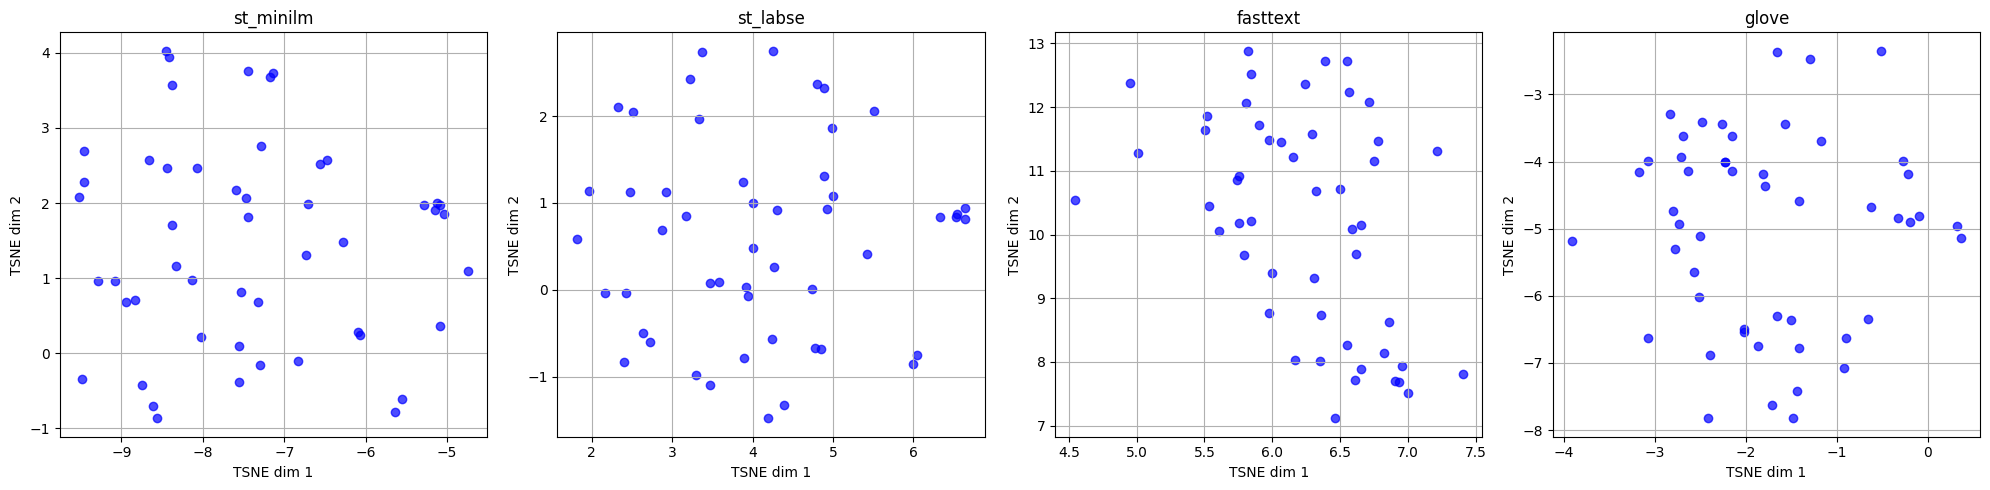

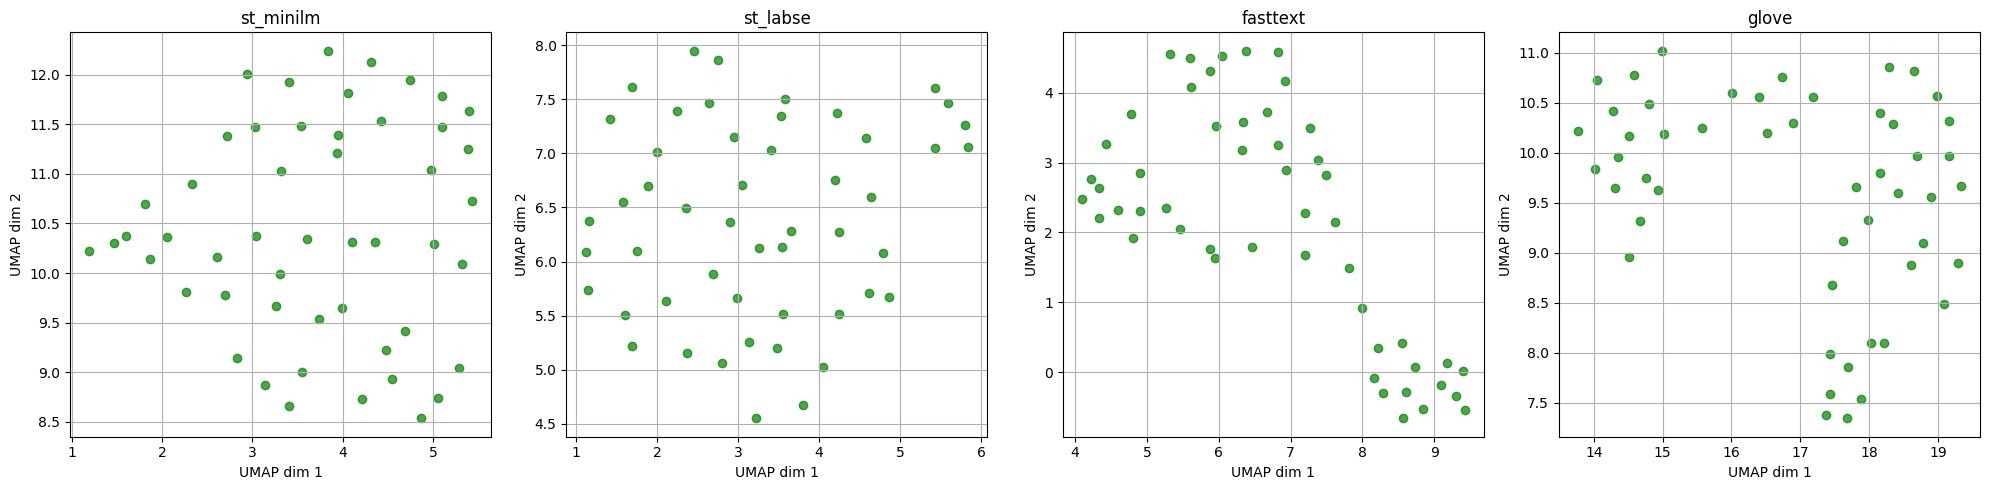

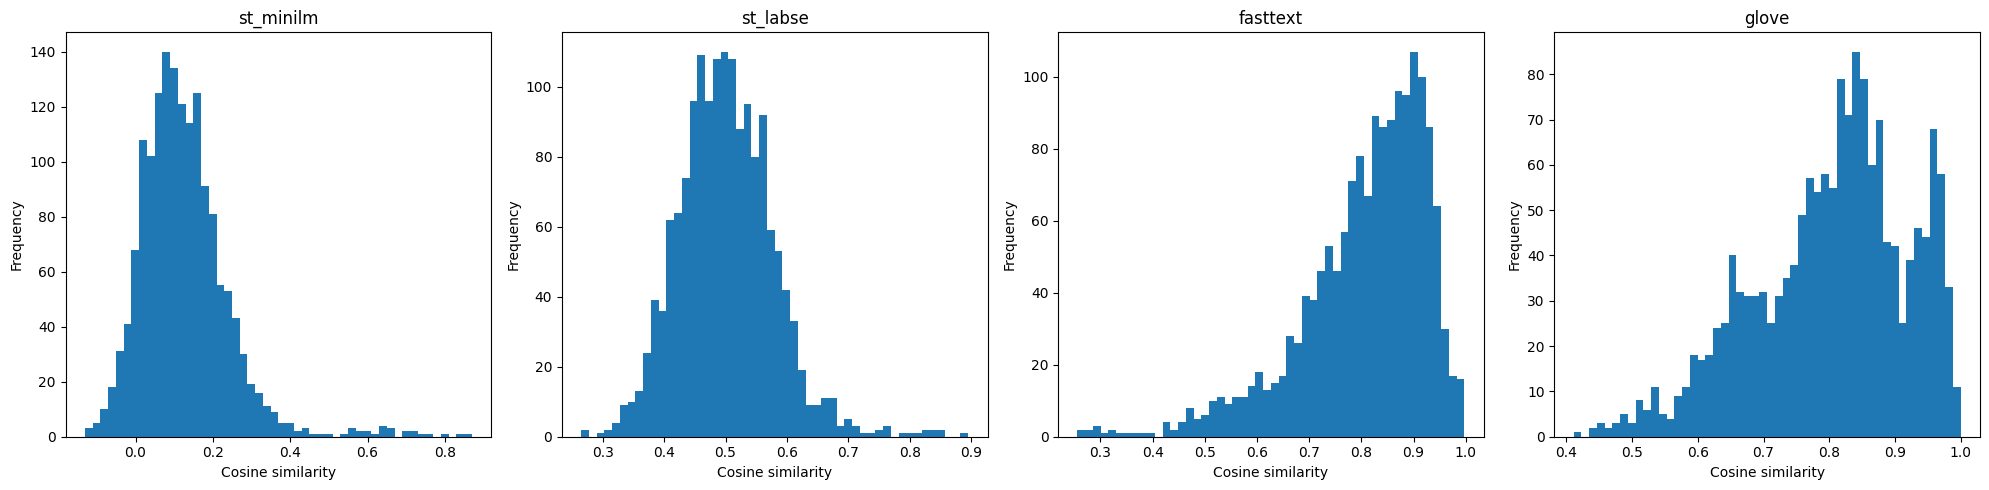

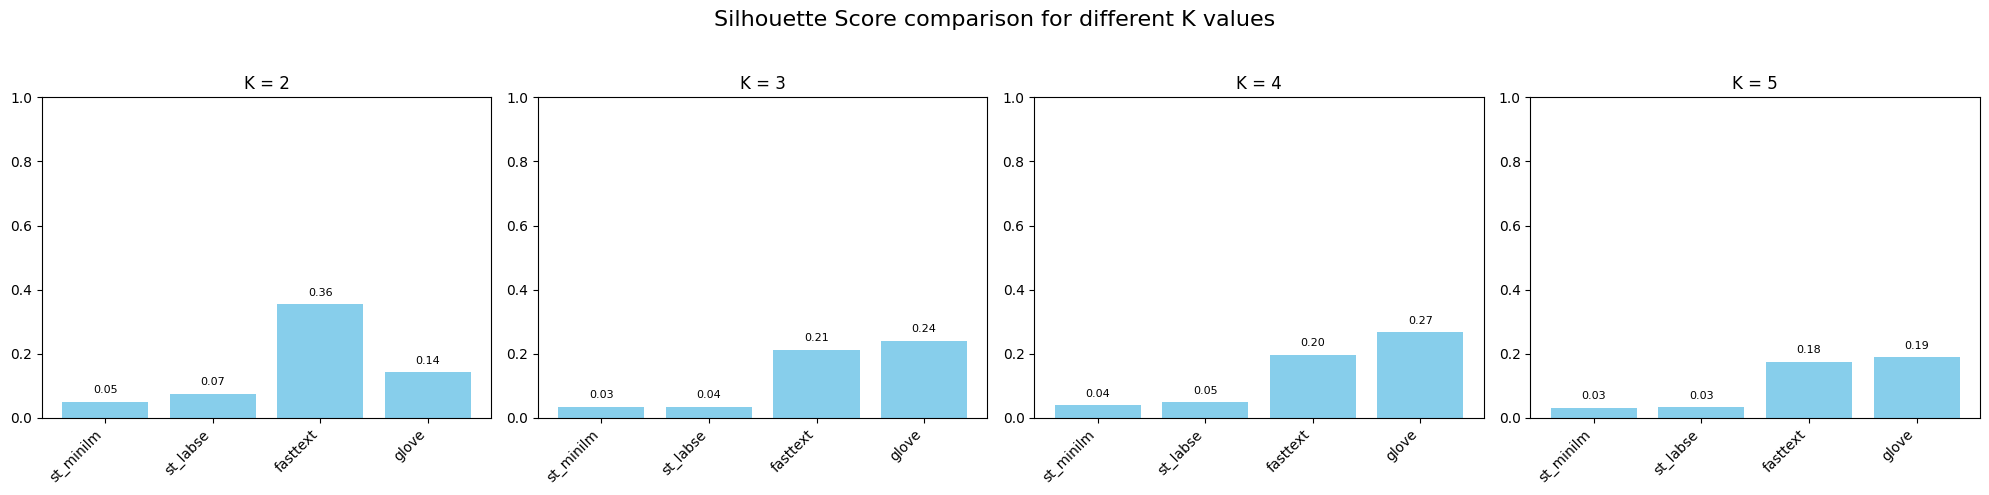

In [68]:
plot_all_heatmaps(embeddings_dict, articles)
plot_all_tsne(embeddings_dict, articles)
plot_all_umap(embeddings_dict, articles)
plot_similarity_histograms(embeddings_dict)
silhouette_barplots(embeddings_dict)

